# Вебинар 2. Бейзлайны и детерминированные алгоритмы item-item

Задача рекомендаций:
1. Мало товаров - предсказание покупки (регрессия)
2. Много товаров, есть разметка релевантности - задача ранжирования (эмбеддинги)
3. Много товаров, купил/не купил - рекомендательные системы (детерменированные, ALS, на основе контента)
4. Много товаров, есть ограничения на коммуникацию - uplift (деревья)

Везде можно применять ансамбли и стеккинг моделей

[RecSys types](https://drive.google.com/file/d/10i5oN2Cw60oLMvnQ4SKFkkotnhRS7Q8L/view?usp=sharing)

In [1]:
!pip install implicit
#==0.4.8

[Implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) - очень быстрая и 
эффективная библиотека для рекоммендаций

Основные фичи:
    - Cython под капотом - высокая скорость
    - Множество приближенных алгоритмов - быстрее, чем оригинальные
    - Содежрит большинство популярных алгоритмов
    - Есть алгоритмы ранжирования
    - Поиск похожих товаров / юзеров
    - Есть возможность пересчета "холодного" юзера "на лету"
    - Возможность фильтровать товары при рекомендациях (Например, не рекомендовать женские товары мужчинам)
    - Есть метрики качества

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [4]:
data = pd.read_csv('retail_train.csv')
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
data['week_no'].nunique()

95

In [5]:
data.shape

(2396804, 12)

In [6]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [7]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


In [8]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

In [9]:
item_features = pd.read_csv('product.csv')
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [10]:
user_features = pd.read_csv('hh_demographic.csv')
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


### Train-test split

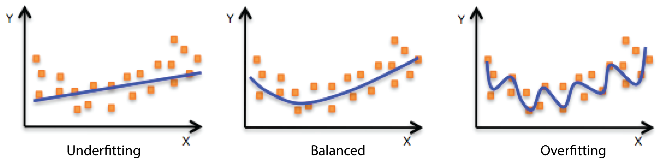

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  
Я возьму последние 3 недели в качестве теста

In [5]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [12]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

# 1. Бейзлайны

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [13]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [14]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [15]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [16]:
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [17]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: total: 5.31 s
Wall time: 5.31 s


In [18]:
items

array([ 1004906,  1033142,  1036325, ..., 15722756, 17170636, 15716393],
      dtype=int64)

In [19]:
result.head(2)

,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977014, 1133418, 996218, 9553382, 7441353]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[996055, 1036054, 1041334, 5565008, 16766163]"


### 1.2 Popularity-based recommendation

In [20]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    #print(recs)
    return recs.tolist()

In [21]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)

CPU times: total: 188 ms
Wall time: 199 ms


In [22]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[977014, 1133418, 996218, 9553382, 7441353]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[996055, 1036054, 1041334, 5565008, 16766163]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### 1.3 Weighted random recommender

- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

*Пример*  
item_1 - 5, item_2 - 7, item_3 - 4  # / sum  
item_1 - 5 / 16, item_2 - 7 / 16, item_3 - 4 / 16

In [23]:
items_weights = data_train['item_id']\
    .value_counts(normalize=True)\
    .reset_index()
items_weights.columns = ['item_id', 'weight']
items_weights.head()

,item_id,weight
0,1082185,0.011467
1,6534178,0.007700
2,1029743,0.005590
3,995242,0.004803
4,1106523,0.003828


In [24]:
print(f'Cумма весов всех элементов: {items_weights.weight.sum()}')

Cумма весов всех элементов: 1.0


In [25]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    items = np.array(items_weights['item_id'])
    weights = np.array(items_weights['weight'])
    recs = np.random.choice(items, size=n, p=weights)
    
    
    return recs.tolist()

In [26]:
%%time

# your_code

result['weighed_radn_rec'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

CPU times: total: 2.44 s
Wall time: 2.44 s


### Выводы по бейзлайнам
- Фиксируют базовое качество;
- Бейзлайны могут быть фильтрами;
- Иногда бейзлайны лучше ML-модели

# 2. Детерминированные алгоритмы item-item

## 2.1 Item-Item Recommender / ItemKNN

[user_item_matrix](https://drive.google.com/file/d/1AtgrATUQ3F60thVGTAN7bpHSSaSESzxP/view?usp=sharing)

То, что именно находится в матрице user-item нужно определять из бизнес-логики

Варианты для нашего датасета(не исчерпывающий список):
    - Факт покупки (0 / 1)
    - Кол-во покупок (count)
    - Сумма покупки, руб
    - ...
    
**Детерминированные алгоритмы**:
    - Предсказывают те числа, которые стоят в матрице

**ML-алгоритмы (большинство)**:
    - В качестве *таргетов* "под капотом" принимают 0 и 1 (в ячейке не 0 -> таргет 1)
    - А абсолютные значения воспринимают как *веса ошибок*
    
*P.S.* На самом деле есть много трюков, как можно заполнять матрицу user-item. Об этом мы поговорим на следующих вебинарах

**Как работает User-User Recommender**

[user_user_recommender](https://drive.google.com/file/d/1qg_ecgjNmymQtfNchzAwxdLCbDXga69Q/view?usp=sharing)

*Шаг 1:* Ищем K ближайших юзеров к целевому юзеру  
*Шаг 2*: predict "скора" товара = среднему "скору" этого товара у его соседей  
*Шаг 3*: Сортируем товары по убыванию predict-ов и берем топ-k

----
**(!) Важно** 
- У item-item алгоритмов большая сложность predict ($O(I^2 log(I))$ или $O(I^3)$, в зависимости от реализации 
- Если в датасете много item_id, то item-item модели ОЧЕНЬ долго предсказывают. Со всеми товарами predict на тесте ~2 часа
- Давайте возьмем из ~90к товаров только 5k самых популярных 

*P.S.*  Брать топ-Х популярных и рекомендовать только из них - очень популярная стратегия.   
*P.P.S.*  В рекомендательных системах много таких трюков. Что-то подобное в курсе вы увидите еще не раз

In [27]:
data.item_id.nunique()

89051

In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [7]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [30]:
len(top_5000)

5000

In [31]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [32]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [33]:
data_train.item_id.nunique()

5001

In [34]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', 
                                  columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
sparse_user_item

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in Compressed Sparse Row format>

In [36]:
user_item_matrix.shape

(2499, 5001)

In [37]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [38]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [39]:
matrix_itemids

array([   0,    1,    2, ..., 4998, 4999, 5000])

In [40]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: total: 1.42 s
Wall time: 674 ms


In [42]:
data_test.user_id.describe()

count    118314.000000
mean       1274.589499
std         718.479723
min           1.000000
25%         679.000000
50%        1282.000000
75%        1917.000000
max        2500.000000
Name: user_id, dtype: float64

In [43]:
userid_to_id[13]

12

In [ ]:
recs = model.recommend(userid=userid_to_id[13],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [ ]:
recs

In [ ]:
recs[0][0]

In [ ]:
[id_to_itemid[item] for item in recs[0]]

In [ ]:
itemid_to_id[999999]

In [ ]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[item] for item in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]
                    ])

In [ ]:
result.head(2)

### 4.2 Косинусное сходство и CosineRecommender

[cosine_similarity](https://drive.google.com/file/d/10kFby5sc2x3aObQHRRyF2Nn9KC2URyCS/view?usp=sharing)

In [ ]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
recs

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])

In [ ]:
result.head(2)

### 4.3 TF-IDF взвешивание и TFIDFRecommender

[tf_idf](https://drive.google.com/file/d/1jEGMzgOCn-dB6F1DqYRZ0RWU0Dcr6h5Q/view?usp=sharing)

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [ ]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)])

In [ ]:
result.head(2)

### 4.4 Трюк - по истории конкретного пользователя (K=1)

In [ ]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)])

### 4.5 Измерим качество по precision@5

In [ ]:
result.head(2)

In [ ]:
result.to_csv('predictions_basic.csv', index=False)

Можно ли улучшить бейзлайны, если считать их на топ-5000 товарах?

In [ ]:
# your_code

In [ ]:
# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k, recall_at_k

In [ ]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [ ]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

In [ ]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()